In [59]:
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from optuna.samplers import GPSampler

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=UserWarning)

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
np.random.seed(42)

# 데이터 로딩 및 전처리
df = pd.read_excel('BMED_train_data_v2.xlsx', sheet_name='Sheet2')
X_data = df[['T','V', 'E', 'CF_LA','CF_K', 'CA_LA', 'CB_K']].values
Y_data = df[['dNLA','dNK','dVF','dVA','dVB']].values


sc = StandardScaler() # 정규분포 정규화

def split_data(random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=random_state)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, Y_train, Y_test

# Custom Model
class CustomModel(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=80): # 인공신경망 구조 초기화
        super().__init__()
        layers = []
        input_dim = X_data.shape[1]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_neurons))
            layers.append(nn.ReLU())
            input_dim = hidden_neurons
        layers.append(nn.Linear(hidden_neurons, 5))
        self.hidden = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden(x)

# TorchRegressor
class TorchRegressor(BaseEstimator, RegressorMixin): # 
    def __init__(self, hidden_layers=2, hidden_neurons=32, learning_rate=0.001, num_epochs=1000, batch_size=64, weight_decay=1e-5): # hyperparameter 초기화
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay # 정규화 파라미터
        self.model = CustomModel(hidden_layers=self.hidden_layers, hidden_neurons=self.hidden_neurons)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y, X_val, y_val, trial=None):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                Y_pred = self.model(X_batch)
                loss = self.criterion(Y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation check
            self.model.eval()
            with torch.no_grad(): # gradient descent 계산 중지 -> 연산 가속화
                val_loss = self.criterion(self.model(X_val_tensor), y_val_tensor)
            # Optuna 관련 코드는 trial이 None이 아닐 때만 실행
            if trial is not None: # pruning 할 때는 not None이라 여기 진입함, 아닌 경우 무시함
                trial.report(val_loss.item(), epoch)
                if trial.should_prune(): # 조기 종료 조건
                    print(f"Trial pruned at epoch {epoch}, val_loss: {val_loss.item()}")
                    raise optuna.exceptions.TrialPruned()

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            Y_pred = self.model(X_tensor)
        return Y_pred.numpy()

# Optuna objective function
def objective(trial):
    # 하이퍼파라미터 검색 공간
    hidden_layers = trial.suggest_int('hidden_layers', 1, 10)
    hidden_neurons = trial.suggest_int('hidden_neurons', 8, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 500, 3000)
    batch_size = trial.suggest_int('batch_size', 32, 128)
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-3, log=True)

    # 데이터 분할
    X_train_,X_test, Y_train_ ,Y_test = split_data(random_state=42)
    # 남은 데이터를 train과 validation으로 분할
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_, Y_train_, test_size=0.2, random_state=42)
    # 모델 학습
    model = TorchRegressor(
        hidden_layers=hidden_layers,
        hidden_neurons=hidden_neurons,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        batch_size=batch_size,
        weight_decay=weight_decay,
    )
    model.fit(X_train, Y_train, X_val, Y_val, trial)
    y_pred = model.predict(X_val)

    # R² Score 계산 (validation set 사용)
    r2 = r2_score(Y_val, y_pred)

    return r2

# Optuna Study 설정
pruner = optuna.pruners.MedianPruner(n_warmup_steps=20, interval_steps=5) # 학습 시 one epoch 내에서 20번은 그냥 학습하고, 이후에 pruning 시작 -> 5스텝마다 pruning 결정
sampler = GPSampler() # gaussian process sampler, hyperparameter를 결정하는 surrogate model 
study = optuna.create_study(direction="maximize", pruner=pruner, sampler=sampler)

# 최대 60번의 trial을 수행
study.optimize(objective, n_trials=60)

# 최종 모델 학습 및 평가
X_train, X_test, Y_train, Y_test = split_data(random_state=42)
final_model = TorchRegressor(**study.best_params)
final_model.fit(X_train, Y_train, X_test, Y_test)

y_pred_test = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

r2_test = r2_score(Y_test, y_pred_test)
r2_train = r2_score(Y_train, y_pred_train)

print(f"Best hyperparameters: {study.best_params}")
print(f"Train R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")


C:\Users\User.DESKTOP-SJB33S8\AppData\Local\Temp\ipykernel_16724\3719888565.py:138: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2025-02-11 17:30:13,965] A new study created in memory with name: no-name-3fae29b2-ab94-48e4-8d01-3f784373e43e
[I 2025-02-11 17:31:28,206] Trial 0 finished with value: 0.8410720378051646 and parameters: {'hidden_layers': 3, 'hidden_neurons': 55, 'learning_rate': 0.0008190038494619395, 'num_epochs': 1360, 'batch_size': 91, 'weight_decay': 1.3314667038007926e-05}. Best is trial 0 with value: 0.8410720378051646.
[I 2025-02-11 17:41:01,671] Trial 1 finished with value: 0.626253189283736 and parameters: {'hidden_layers': 6, 'hidden_neurons': 122, 'learning_rate': 0.00016116288241675535, 'num_epochs': 2168, 'batch_size': 81, 'weight_decay': 0.0007129494828290548}. Best is trial 0 with value: 0.8410720378051646.
[I 2025-02-11 17:42:25,200] Trial 2 finished with value: 0.8339303599434332 and para

Best hyperparameters: {'hidden_layers': 7, 'hidden_neurons': 119, 'learning_rate': 0.00022090701421001295, 'num_epochs': 3000, 'batch_size': 128, 'weight_decay': 1e-07}
Train R²: 0.9864
Test R²: 0.9546


In [60]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
              'y': [0.8410720378051646, 0.626253189283736, 0.8339303599434332,
                    0.6387836339429473, 0.8726768120043099, 0.7499280415393523,
                    0.6792716333954484, 0.653518050680594, 0.5180302626037474,
                    0.8052042696694862, 0.8979613790756794, 0.8386777959224954,
                    0.8361136698136814, 0.865977648137712, 0.8989112390678864,
                    0.8057552195709972, 0.8645574475217546, 0.8616294067647159,
                    0.9168330120420407, 0.8903299632617117, 0.654896637287203,
                    0.8930521571473303, 0.911038483561265, 0.8285864040562417,
                    0.8800896559593931, 0.8872507924890425, 0.7566323429263938,
                    0.7021742502231453, 0.8853668519773314, 0.738347109556542,
                    0.9017713507798154, 0.8975587106126582, 0.8974653671550399,
                    0.8782752140976999, 0.8984399837400268, 0.9063642403949645,
                    0.7585928225899687, 0.8036365457860754, 0.8811536500457672,
                    0.8878664505920394, 0.7299066483519038, 0.9368272285849486,
                    0.8523748386843761, 0.9002390691802749, 0.40217141912437404,
                    0.8740960791344212, 0.9040822124399881, 0.8806644031025226,
                    0.8196158924799228, 0.778681764994893, 0.6694826445145623,
                    0.8433142961930891, 0.9035323235893638, 0.8786542817236814,
                    0.7659656642731758, 0.8428058695252603, 0.899596931635271,
                    0.8912605898299573, 0.9004140077203269, 0.6246969072331062]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
              'y': [0.8410720378051646, 0.8410720378051646, 0.8410720378051646,
                    0.8410720378051646, 0.8726768120043099, 0.8726768120043099,
                    0.8726768120043099, 0.8726768120043099, 0.8726768120043099,
                    0.8726768120043099, 0.8979613790756794, 0.8979613790756794,
                    0.8979613790756794, 0.8979613790756794, 0.8989112390678864,
                    0.8989112390678864, 0.8989112390678864, 0.8989112390678864,
                    0.9168330120420407, 0.9168330120420407, 0.9168330120420407,
                    0.9168330120420407, 0.9168330120420407, 0.9168330120420407,
                    0.9168330120420407, 0.9168330120420407, 0.9168330120420407,
                    0.9168330120420407, 0.9168330120420407, 0.9168330120420407,
                    0.9168330120420407, 0.9168330120420407, 0.9168330120420407,
                    0.9168330120420407, 0.9168330120420407, 0.9168330120420407,
                    0.9168330120420407, 0.9168330120420407, 0.9168330120420407,
                    0.9168330120420407, 0.9168330120420407, 0.9368272285849486,
                    0.9368272285849486, 0.9368272285849486, 0.9368272285849486,
                    0.9368272285849486, 0.9368272285849486, 0.9368272285849486,
                    0.9368272285849486, 0.9368272285849486, 0.9368272285849486,
                    0.9368272285849486, 0.9368272285849486, 0.9368272285849486,
                    0.9368272285849486, 0.9368272285849486, 0.9368272285849486,
                    0.9368272285849486, 0.93682

In [61]:
# 최종 모델 학습 및 평가
X_train, X_test, Y_train, Y_test = split_data(random_state=42)
final_model = TorchRegressor(**study.best_params)
final_model.fit(X_train, Y_train, X_test, Y_test)  # X_test, Y_test를 검증 데이터로 사용

y_pred_test = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

r2_test = r2_score(Y_test, y_pred_test)
r2_train = r2_score(Y_train, y_pred_train)

print(f"Best hyperparameters: {study.best_params}")
print(f"Train R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")

Best hyperparameters: {'hidden_layers': 7, 'hidden_neurons': 119, 'learning_rate': 0.00022090701421001295, 'num_epochs': 3000, 'batch_size': 128, 'weight_decay': 1e-07}
Train R²: 0.9876
Test R²: 0.9589


R² Score: 0.9589321006459439


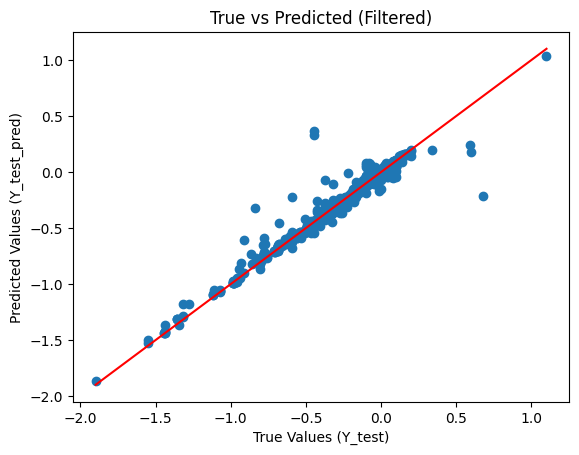

In [63]:
import matplotlib.pyplot as plt

plt.scatter(Y_test,y_pred_test)
plt.plot([np.min(Y_test), np.max(Y_test)], [np.min(Y_test), np.max(Y_test)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

r2_test = r2_score(Y_test, y_pred_test)
print(f"R² Score: {r2_test}")

#print(max(abs(Y_test - x_pred_test)))
#print(np.argmax(abs(Y_test - x_pred_test)))

R² Score: 0.9875630009928414


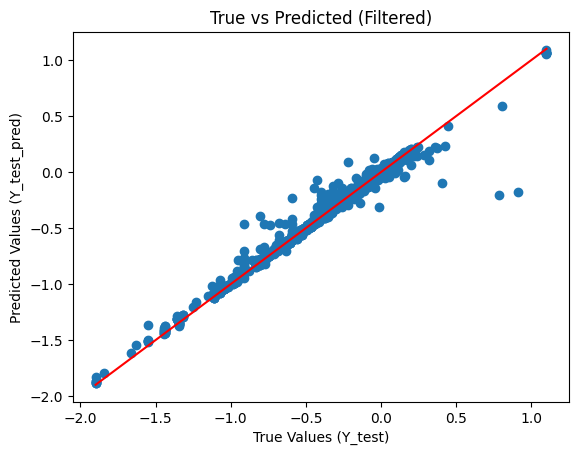

In [64]:
plt.scatter(Y_train, y_pred_train)
plt.plot([np.min(Y_train), np.max(Y_train)], [np.min(Y_train), np.max(Y_train)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

r2_train = r2_score(Y_train, y_pred_train)

print(f"R² Score: {r2_train}")

R² Score: 0.9826570890178743


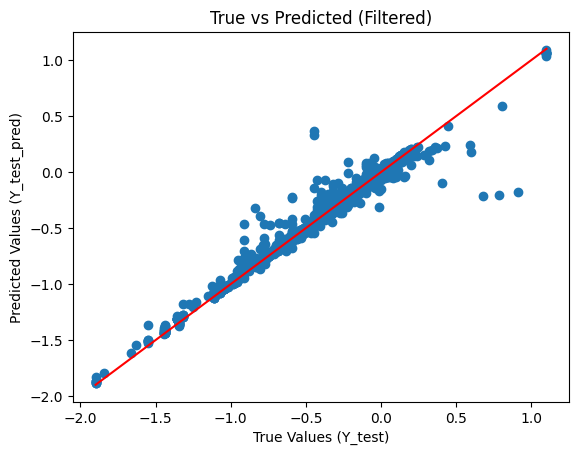

In [65]:
Y_data = np.concatenate((Y_train, Y_test), axis=0)
y_pred = np.concatenate((y_pred_train, y_pred_test), axis=0)
plt.scatter(Y_data, y_pred)
plt.plot([np.min(Y_data), np.max(Y_data)], [np.min(Y_data), np.max(Y_data)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')
r2 = r2_score(Y_data, y_pred)
print(f"R² Score: {r2}")

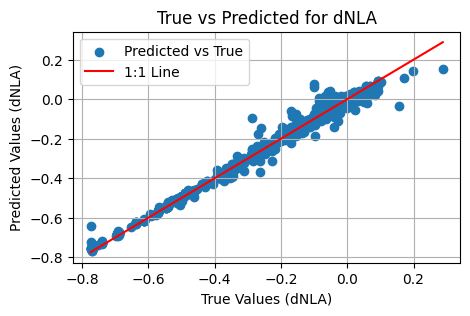

dNLA - R² Score: 0.9931


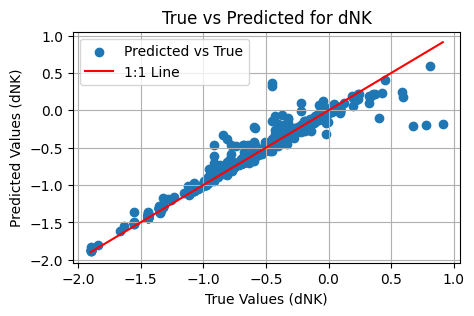

dNK - R² Score: 0.9752


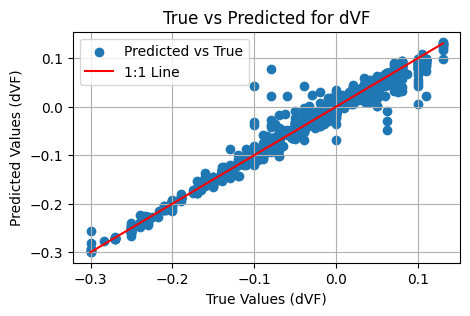

dVF - R² Score: 0.9775


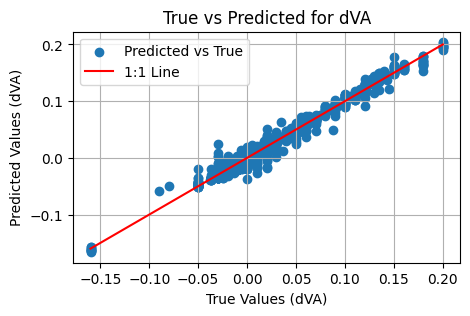

dVA - R² Score: 0.9816


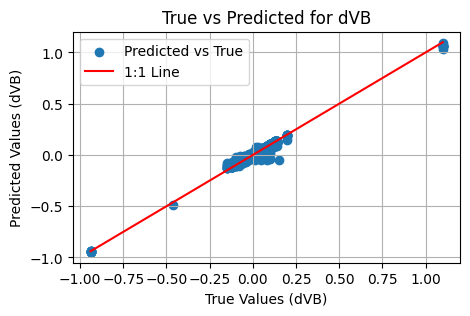

dVB - R² Score: 0.9859


In [67]:
# 각 출력 변수별로 그래프 그리기
output_names = ['dNLA', 'dNK', 'dVF', 'dVA', 'dVB']  # 출력 변수 이름 (Y_data의 열 이름)
for i in range(Y_data.shape[1]):
    Y_data_combined = np.concatenate((Y_train[:, i], Y_test[:, i]), axis=0)
    y_pred_combined = np.concatenate((y_pred_train[:, i], y_pred_test[:, i]), axis=0)

    plt.figure(figsize=(5, 3))
    plt.scatter(Y_data_combined, y_pred_combined, label='Predicted vs True')
    plt.plot([np.min(Y_data_combined), np.max(Y_data_combined)],
             [np.min(Y_data_combined), np.max(Y_data_combined)], color='red', label='1:1 Line')  # 1:1 직선
    plt.xlabel(f'True Values ({output_names[i]})')
    plt.ylabel(f'Predicted Values ({output_names[i]})')
    plt.title(f'True vs Predicted for {output_names[i]}')
    plt.legend()
    plt.grid()
    plt.savefig(f'output_{output_names[i]}_plot.png')  # 그래프를 PNG 파일로 저장
    plt.show()

    # R² 계산 및 출력
    r2 = r2_score(Y_data_combined, y_pred_combined)
    print(f"{output_names[i]} - R² Score: {r2:.4f}")